In [1]:
# installing packages
import sys
sys.path.append("../../bankruptcy_prediction")
import pandas as pd
import numpy as np
import sys
# for visualisation
import plotly.io as pio
pio.templates.default = "ggplot2"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


# for modelling 
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

import optuna
import imblearn as imb
from collections import Counter

from sklearn.metrics import (PrecisionRecallDisplay, precision_score,
recall_score,confusion_matrix,f1_score)
from sklearn.model_selection import train_test_split
import shap
from utils import (get_shap_feat_importance,check_missing, 
plot_dist_bar, get_dist, read_xlsx, model_performance)


In [2]:
training_data = pd.read_csv("../data/training_data.csv")
testing_data = pd.read_csv("../data/testing_data.csv")
highcorr90 = pd.read_csv("../data/highcorr90.csv")
target="bankruptcy"

data = pd.concat([training_data,testing_data],axis=0).reset_index(drop=True)
print("Original Data Shape",data.shape)

data["company_type"] = data["company_type"].astype("category")

holdout=data.iloc[:50,:]
data = data.iloc[50:,:] 
print("Shape after dropping",data.shape)
X,y = data.drop(target,axis=1),data[target]

#Holdout
print("Shape of holdout",holdout.shape)
print(Counter(holdout[target]))

Original Data Shape (6811, 96)
Shape after dropping (6761, 96)
Shape of holdout (50, 96)
Counter({0: 47, 1: 3})


In [3]:
sampling_strategy=False
if sampling_strategy:
    # define oversampling strategy
    # oversample = RandomOverSampler(sampling_strategy='minority')
    oversample = imb.over_sampling.RandomOverSampler(sampling_strategy=0.06)
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    print(Counter(y_over))
else :
    X_over = X.copy(deep=True)
    y_over = y.copy(deep=True)
    print(Counter(y_over))

Counter({0: 6545, 1: 216})


In [4]:
X_train,X_test,y_train,y_test = \
    train_test_split(X_over,y_over,test_size=0.3, stratify=y,random_state=42)

In [5]:
# X_train,y_train = training_data.drop("bankruptcy",axis = 1),training_data['bankruptcy']
# X_test,y_test = testing_data.drop("bankruptcy",axis = 1),testing_data['bankruptcy']
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 4581, 1: 151})
Counter({0: 1964, 1: 65})


### Benchmark Model

Train classification report: 
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      4581
           1       0.06      0.43      0.10       151

    accuracy                           0.76      4732
   macro avg       0.52      0.60      0.48      4732
weighted avg       0.95      0.76      0.84      4732

Test classification report: 
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1964
           1       0.06      0.42      0.10        65

    accuracy                           0.77      2029
   macro avg       0.52      0.60      0.48      2029
weighted avg       0.95      0.77      0.84      2029



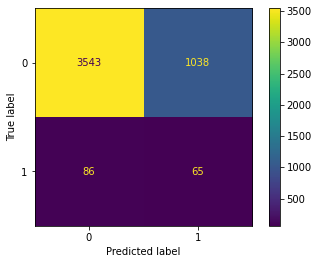

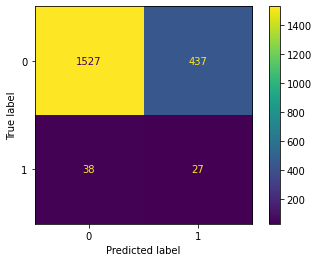

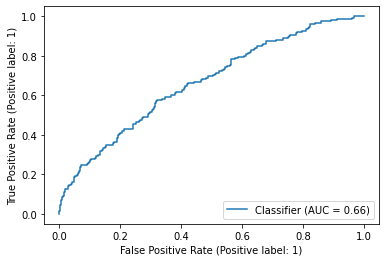

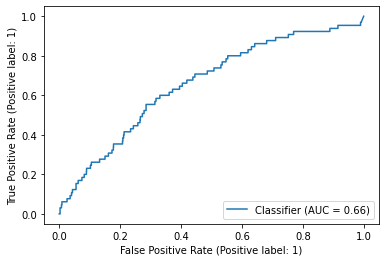

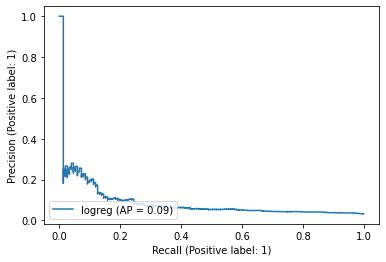

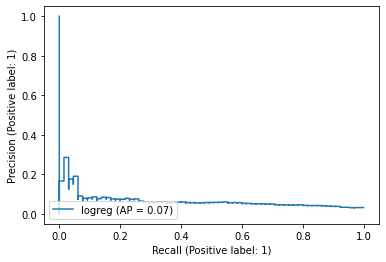

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay


ohe = OneHotEncoder()

drop_high_corr = list(highcorr90["feat1"])
cat_cols = ["company_type"]
drop_cols_lr = drop_high_corr+cat_cols 
X_train_ohe = ohe.fit_transform(X_train[cat_cols]).toarray()
X_test_ohe = ohe.transform(X_test[cat_cols]).toarray()

X_train_lr = X_train.drop(drop_cols_lr,axis=1).copy(deep=True)
X_test_lr = X_test.drop(drop_cols_lr,axis=1).copy(deep=True)

X_train_lr[ohe.categories_[0]] = X_train_ohe
X_test_lr[ohe.categories_[0]] = X_test_ohe


benchmark_mod = LogisticRegression(class_weight="balanced")
benchmark_mod.fit(X_train_lr,y_train)

pred_train_lr = benchmark_mod.predict_proba(X_train_lr)
pred_test_lr = benchmark_mod.predict_proba(X_test_lr)

model_performance(y_true_train=y_train,y_true_test=y_test, 
y_pred_train=pred_train_lr,y_pred_test=pred_test_lr,
threshold=0.5,title="logreg")

In [7]:
# bbc = imb.ensemble.BalancedRandomForestClassifier(class_weight={0: 4581, 1: 151}).fit(X_train_lr,y_train)
# pred_train_bbc = bbc.predict_proba(X_train_lr)
# pred_test_bbc = bbc.predict_proba(X_test_lr)

# model_performance(y_pred=pred_train_bbc,y_true=y_train,threshold=0.5,
# title="bbc:TRAIN",model_type="bbc")

# model_performance(y_pred=pred_test_bbc,y_true=y_test,threshold=0.5,
# title="bbc:TEST",model_type="bbc")


In [8]:

def full_data(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 10,50),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli","MVS"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "scale_pos_weight":trial.suggest_int("scale_pos_weight", 2,30)
        #"grow_policy": trial.suggest_categorical("grow_policy",["SymmetricTree"])
        }
    

    # if param["objective"] == "LogLoss":
    #     param["scale_pos_weight"]:trial.suggest_int("scale_pos_weight", 2,30)
    #     #y_train.value_counts()[0]/y_train.value_counts()[1]
        # param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, 
    early_stopping_rounds=10,cat_features=["company_type"]
    )

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [9]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study1 = optuna.create_study(direction="maximize")
study1.optimize(full_data, n_trials=50, timeout=600,show_progress_bar=True)

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
print("Number of finished trials: {}".format(len(study1.trials)))

print("Best trial:")
trial = study1.best_trial

print("  Value: {}".format(trial.value))

best_params={}
print("  Params: ")
for key, value in trial.params.items():
    best_params[key]=value
print(best_params)

Number of finished trials: 50
Best trial:
  Value: 0.4720496894409938
  Params: 
{'objective': 'Logloss', 'colsample_bylevel': 0.08892053853558361, 'learning_rate': 0.022861790336884253, 'depth': 5, 'iterations': 30, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered', 'scale_pos_weight': 9, 'subsample': 0.29289433912595797}


In [11]:
extra_params = {"cat_features":["company_type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":10
    #y_train.value_counts()[0]/y_train.value_counts()[1] 
    # "auto_class_weights":"Balanced"
    }
best_params = {**best_params, **extra_params}


In [12]:
best_params

{'objective': 'Logloss',
 'colsample_bylevel': 0.08892053853558361,
 'learning_rate': 0.022861790336884253,
 'depth': 5,
 'iterations': 30,
 'l2_leaf_reg': 3,
 'bootstrap_type': 'Bernoulli',
 'boosting_type': 'Ordered',
 'scale_pos_weight': 9,
 'subsample': 0.29289433912595797,
 'cat_features': ['company_type']}

In [13]:
mod2 = CatBoostClassifier(**best_params)

mod2.fit(X_train,y_train)

# Get predicted probabilities for each class
pred_train_cat = mod2.predict_proba(X_train)
pred_test_cat = mod2.predict_proba(X_test)

0:	learn: 0.6718289	total: 20.6ms	remaining: 598ms
1:	learn: 0.6497680	total: 37.3ms	remaining: 522ms
2:	learn: 0.6214230	total: 56.9ms	remaining: 512ms
3:	learn: 0.5994619	total: 68.5ms	remaining: 445ms
4:	learn: 0.5802667	total: 82.8ms	remaining: 414ms
5:	learn: 0.5655628	total: 95.2ms	remaining: 381ms
6:	learn: 0.5543575	total: 107ms	remaining: 350ms
7:	learn: 0.5358043	total: 119ms	remaining: 328ms
8:	learn: 0.5210798	total: 131ms	remaining: 305ms
9:	learn: 0.5023892	total: 143ms	remaining: 285ms
10:	learn: 0.4900983	total: 153ms	remaining: 264ms
11:	learn: 0.4799898	total: 165ms	remaining: 247ms
12:	learn: 0.4672305	total: 177ms	remaining: 231ms
13:	learn: 0.4560853	total: 188ms	remaining: 215ms
14:	learn: 0.4452755	total: 199ms	remaining: 199ms
15:	learn: 0.4326786	total: 211ms	remaining: 184ms
16:	learn: 0.4256908	total: 221ms	remaining: 169ms
17:	learn: 0.4135722	total: 231ms	remaining: 154ms
18:	learn: 0.4052863	total: 250ms	remaining: 145ms
19:	learn: 0.3955175	total: 266ms	r

Train classification report: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4581
           1       0.36      0.67      0.47       151

    accuracy                           0.95      4732
   macro avg       0.68      0.82      0.72      4732
weighted avg       0.97      0.95      0.96      4732

Test classification report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1964
           1       0.40      0.58      0.47        65

    accuracy                           0.96      2029
   macro avg       0.69      0.78      0.73      2029
weighted avg       0.97      0.96      0.96      2029



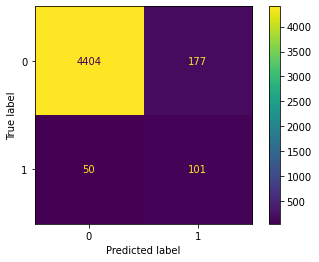

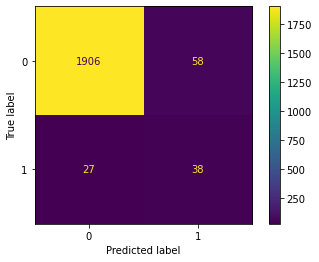

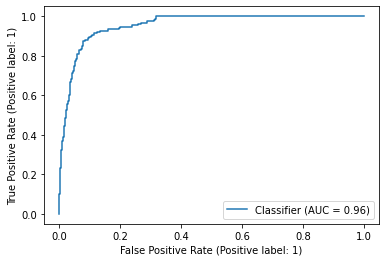

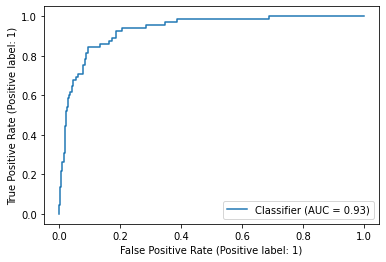

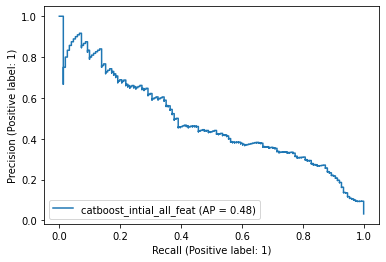

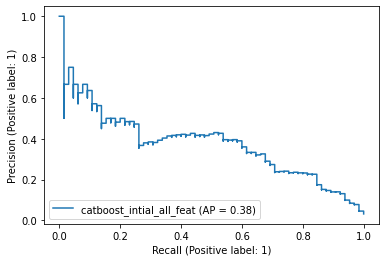

In [14]:
# model_performance(y_pred=pred_train_cat,y_true=y_train,threshold=0.5,
# title="catboost:TRAIN",model_type="catboost")

# model_performance(y_pred=pred_test_cat,y_true=y_test,threshold=0.5,
# title="catboost:TEST",model_type="catboost")

model_performance(y_true_train=y_train,y_true_test=y_test, 
y_pred_train=pred_train_cat,y_pred_test=pred_test_cat,
threshold=0.5,title="catboost_intial_all_feat")

In [15]:
explainer2 = shap.TreeExplainer(mod2)
shap_values2 = explainer2.shap_values(X_train)

In [16]:
top=50
importance_mod2 = get_shap_feat_importance(shap_values2,X_train)
importance_topk = importance_mod2[importance_mod2["shap_importance"]>0][:top]
best_feat = importance_topk.features.values

Net Worth: Net worth is the value of the assets a person or corporation owns, minus the liabilities they owe.

Debt Ratio = $\frac{TotalDebt}{TotalAssets}$

Class A and B shares: The difference between Class A shares and Class B shares of a company’s stock usually comes down to the number of voting rights assigned to the shareholder. Class A shareholders generally have more clout.

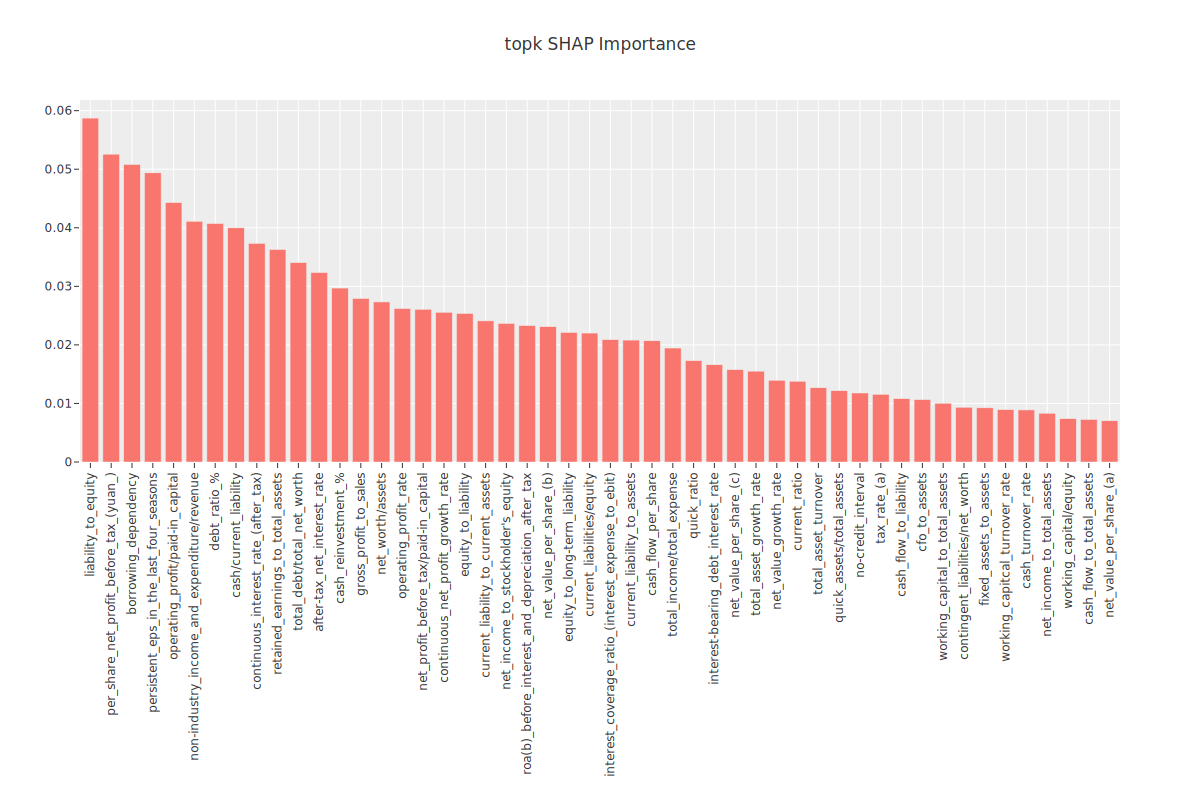

In [17]:
fig = go.Figure([go.Bar(x=importance_topk.features, y=importance_topk.shap_importance)])
fig.update_layout(width=1200, height=800,xaxis_tickangle=-90, title="topk SHAP Importance")
fig.show("svg")


In [18]:
if X_train[best_feat].select_dtypes(exclude=np.number).shape[1]>0:
    print(f"categorical feature detected")
else: 
    print(f"NO categorical feature detected")

NO categorical feature detected


In [19]:

def obj_best_feat(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 10,50),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli","MVS"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "scale_pos_weight":trial.suggest_int("scale_pos_weight", 2,30)
        #"grow_policy": trial.suggest_categorical("grow_policy",["SymmetricTree"])
        }
    

    # if param["objective"] == "LogLoss":
    #     param["scale_pos_weight"]:trial.suggest_int("scale_pos_weight", 2,30)
    #     #y_train.value_counts()[0]/y_train.value_counts()[1]
        # param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train[best_feat], y_train, eval_set=[(X_test[best_feat], y_test)], verbose=0, 
    early_stopping_rounds=10#,cat_features=["company type"]
    )

    preds = gbm.predict(X_test[best_feat])
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [20]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(obj_best_feat, n_trials=50, timeout=600,show_progress_bar=True)

/Users/convergeml/engineering/casestudy/bankruptcy_prediction/.venv/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
print("Number of finished trials: {}".format(len(study2.trials)))

print("Best trial:")
trial2 = study2.best_trial

print("  Value: {}".format(trial2.value))

best_params2={}
print("  Params: ")
for key, value in trial2.params.items():
    best_params2[key]=value
print(best_params2)

Number of finished trials: 50
Best trial:
  Value: 0.48920863309352514
  Params: 
{'objective': 'Logloss', 'colsample_bylevel': 0.0979504361733678, 'learning_rate': 0.050699390622994916, 'depth': 10, 'iterations': 30, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered', 'scale_pos_weight': 5, 'subsample': 0.9711541971538866}


In [22]:
extra_params = {
    #"cat_features":["company type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1] 
    #"auto_class_weights":"Balanced"
    }

best_params2 = {**best_params2, **extra_params}

In [23]:
best_params2

{'objective': 'Logloss',
 'colsample_bylevel': 0.0979504361733678,
 'learning_rate': 0.050699390622994916,
 'depth': 10,
 'iterations': 30,
 'l2_leaf_reg': 6,
 'bootstrap_type': 'Bernoulli',
 'boosting_type': 'Ordered',
 'scale_pos_weight': 5,
 'subsample': 0.9711541971538866}

In [24]:
# using earlier saved params since they gave better performance
#best_params2 = pd.read_csv("../data/best_params.csv",index_col=False).to_dict('records')[0]

In [30]:
# # saving params to csv
# best_params2_df = pd.DataFrame([best_params2])
# best_params2_df.to_csv("../data/best_params.csv",index=False)

In [26]:
mod3 = CatBoostClassifier(**best_params2)

mod3.fit(X_train[best_feat],y_train)

# Get predicted probabilities for each class
pred_train_cat3 = mod3.predict_proba(X_train[best_feat])
pred_test_cat3 = mod3.predict_proba(X_test[best_feat])

0:	learn: 0.6189927	total: 100ms	remaining: 2.9s
1:	learn: 0.5478639	total: 165ms	remaining: 2.31s
2:	learn: 0.4955882	total: 247ms	remaining: 2.23s
3:	learn: 0.4527250	total: 289ms	remaining: 1.88s
4:	learn: 0.4123829	total: 386ms	remaining: 1.93s
5:	learn: 0.3858996	total: 389ms	remaining: 1.56s
6:	learn: 0.3600479	total: 396ms	remaining: 1.3s
7:	learn: 0.3351752	total: 484ms	remaining: 1.33s
8:	learn: 0.3111587	total: 567ms	remaining: 1.32s
9:	learn: 0.2922183	total: 645ms	remaining: 1.29s
10:	learn: 0.2799073	total: 649ms	remaining: 1.12s
11:	learn: 0.2687831	total: 720ms	remaining: 1.08s
12:	learn: 0.2537688	total: 783ms	remaining: 1.02s
13:	learn: 0.2437106	total: 890ms	remaining: 1.02s
14:	learn: 0.2350023	total: 945ms	remaining: 945ms
15:	learn: 0.2281647	total: 1.02s	remaining: 891ms
16:	learn: 0.2203231	total: 1.07s	remaining: 816ms
17:	learn: 0.2127027	total: 1.15s	remaining: 764ms
18:	learn: 0.2060583	total: 1.18s	remaining: 685ms
19:	learn: 0.1999272	total: 1.27s	remaining

Train classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4581
           1       0.55      0.72      0.62       151

    accuracy                           0.97      4732
   macro avg       0.77      0.85      0.81      4732
weighted avg       0.98      0.97      0.97      4732

Test classification report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1964
           1       0.46      0.52      0.49        65

    accuracy                           0.97      2029
   macro avg       0.72      0.75      0.74      2029
weighted avg       0.97      0.97      0.97      2029



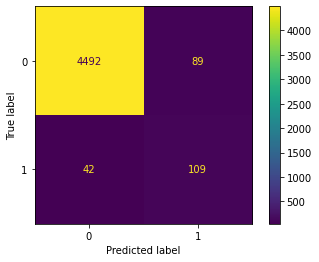

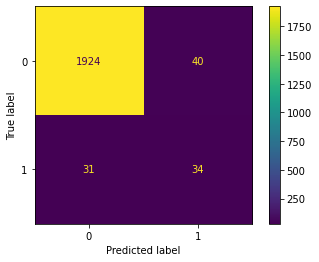

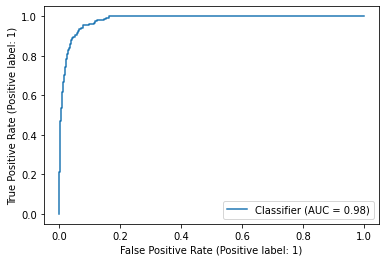

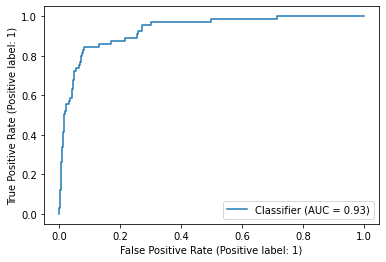

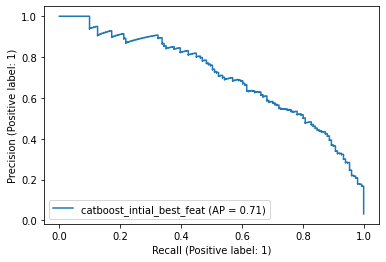

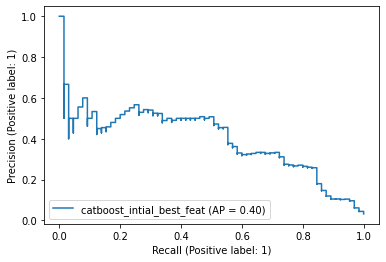

In [27]:
model_performance(y_true_train=y_train,y_true_test=y_test, 
y_pred_train=pred_train_cat3,y_pred_test=pred_test_cat3,
threshold=0.5,title="catboost_intial_best_feat")

Train classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4581
           1       0.55      0.72      0.62       151

    accuracy                           0.97      4732
   macro avg       0.77      0.85      0.81      4732
weighted avg       0.98      0.97      0.97      4732

Test classification report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        47
           1       0.50      0.33      0.40         3

    accuracy                           0.94        50
   macro avg       0.73      0.66      0.68        50
weighted avg       0.93      0.94      0.93        50



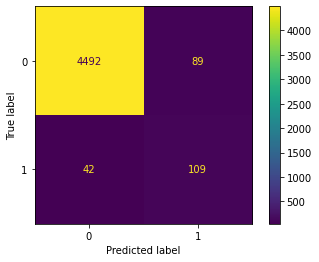

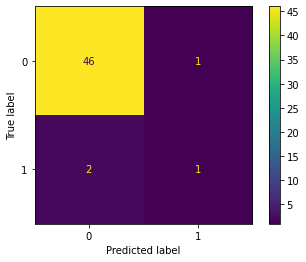

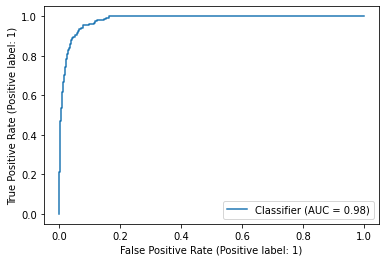

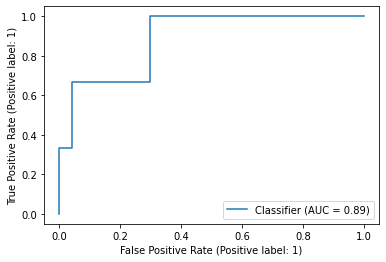

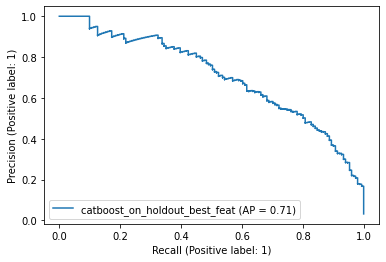

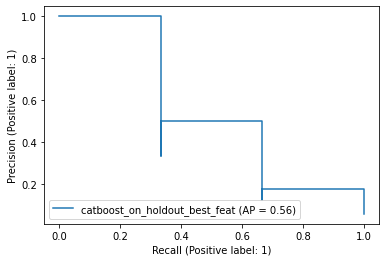

In [28]:
holdout_df = holdout.drop(target,axis = 1)[best_feat]
pred_holdout_cat = mod3.predict_proba(holdout_df)

model_performance(y_true_train=y_train,y_true_test=holdout[target], 
y_pred_train=pred_train_cat3,y_pred_test=pred_holdout_cat,
threshold=0.5,title="catboost_on_holdout_best_feat")

In [29]:
#saving model
mod3.save_model(fname="../model/catboost_model",format="cbm")

In [31]:
explainer3 = shap.TreeExplainer(mod3)
shap_values3 = explainer3.shap_values(X_train[best_feat])

In [46]:
importance_mod2 = get_shap_feat_importance(shap_values3,X_train[best_feat])
best_feat3 = list(importance_mod2.features.values)
best_feat3

['interest-bearing_debt_interest_rate',
 'non-industry_income_and_expenditure/revenue',
 'operating_profit/paid-in_capital',
 'borrowing_dependency',
 'total_debt/total_net_worth',
 'liability_to_equity',
 'after-tax_net_interest_rate',
 'retained_earnings_to_total_assets',
 'current_liability_to_current_assets',
 'net_value_per_share_(c)',
 "net_income_to_stockholder's_equity",
 'net_profit_before_tax/paid-in_capital',
 'roa(b)_before_interest_and_depreciation_after_tax',
 'per_share_net_profit_before_tax_(yuan_)',
 'quick_ratio',
 'debt_ratio_%',
 'net_worth/assets',
 'no-credit_interval',
 'equity_to_long-term_liability',
 'total_income/total_expense',
 'equity_to_liability',
 'persistent_eps_in_the_last_four_seasons',
 'cash_flow_to_liability',
 'net_value_growth_rate',
 'continuous_interest_rate_(after_tax)',
 'cash_flow_to_total_assets',
 'current_ratio',
 'current_liabilities/equity',
 'tax_rate_(a)',
 'gross_profit_to_sales',
 'operating_profit_rate',
 'net_value_per_share_(b)'

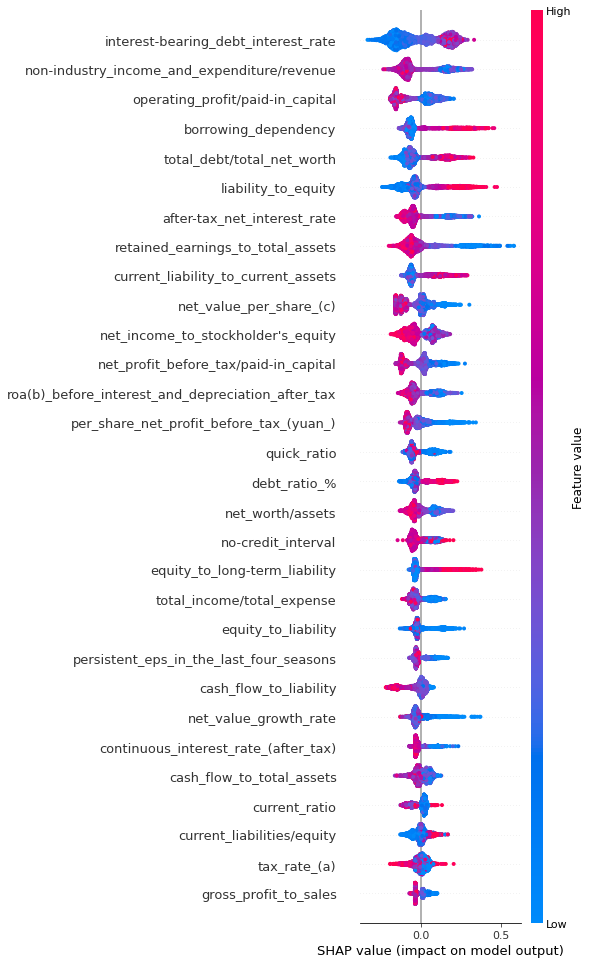

In [32]:
shap.summary_plot(shap_values3,X_train[best_feat],max_display=30)

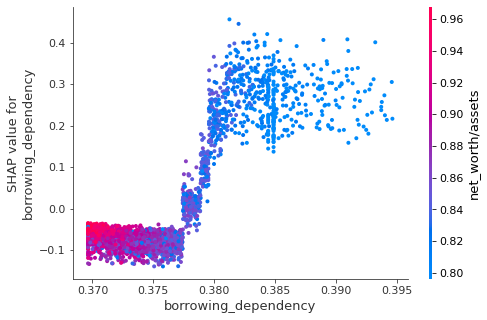

In [33]:
shap.dependence_plot("borrowing_dependency", shap_values3, X_train[best_feat],interaction_index="net_worth/assets")

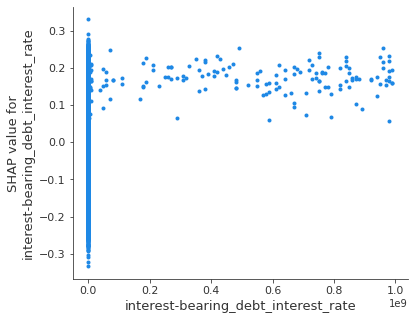

In [35]:
shap.dependence_plot("interest-bearing_debt_interest_rate", shap_values3, X_train[best_feat],interaction_index=None)

'non-industry_income_and_expenditure/revenue'

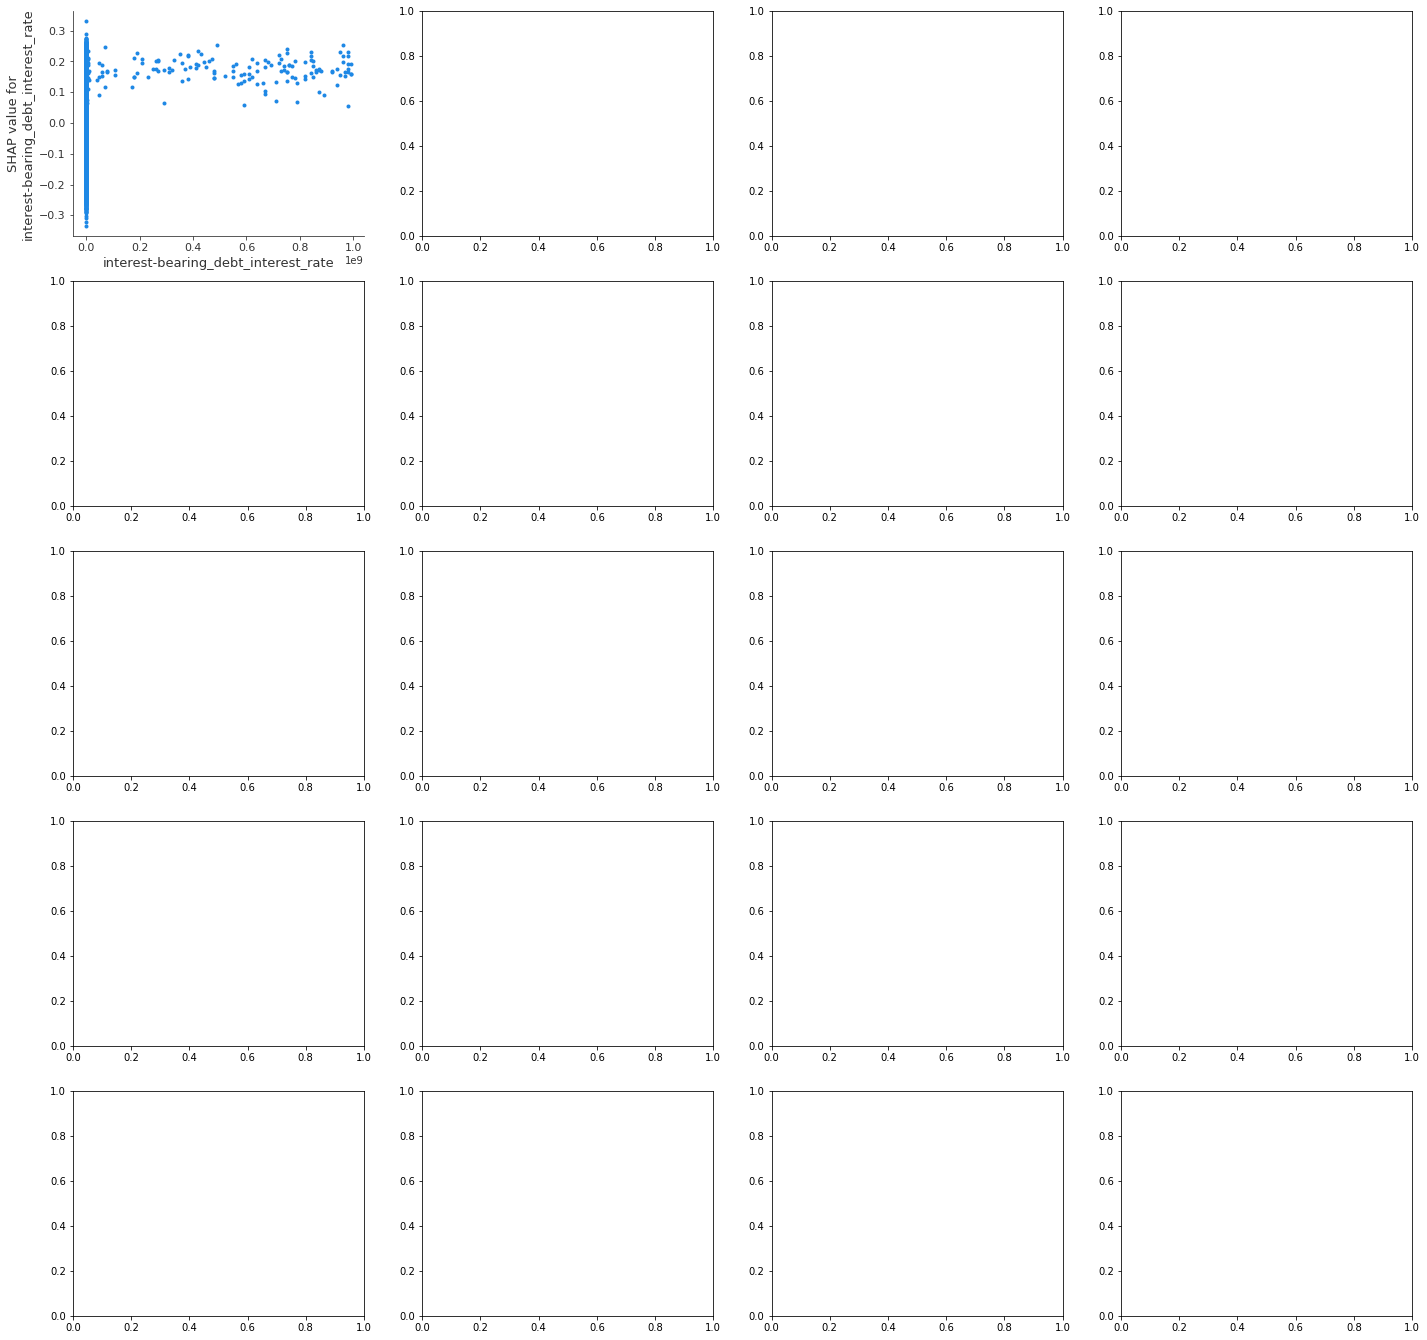

In [61]:
_, axes = plt.subplots(nrows=5,ncols=4,figsize=(24,24))
k=-1
for i in range(5):
    for j in range(4):
        print(i,j)
        print(k)
        k+=1
        var = str(best_feat3[k])
        _ = shap.dependence_plot(var, shap_values3, X_train[best_feat],interaction_index=None,ax=axes[i,j])        
        if c==20:
            break
plt.show()